# Example-37: Orbit (dispersion correction)

In [1]:
# In this example derivatives of dispersion with respect to different deviation parameters are computed
# These derivatives are then used to fit ideal model to observations
# Direct optimization using differentiable orbit and dispersion is also performed

In [2]:
# Import

from pprint import pprint

import torch

from pathlib import Path

import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['text.usetex'] = True

from twiss import twiss

from model.library.line import Element
from model.library.corrector import Corrector
from model.library.line import Line

from model.command.util import chop
from model.command.util import select

from model.command.external import load_sdds
from model.command.external import load_lattice

from model.command.build import build

from model.command.wrapper import group
from model.command.wrapper import forward
from model.command.wrapper import inverse
from model.command.wrapper import normalize
from model.command.wrapper import Wrapper

from model.command.orbit import orbit
from model.command.orbit import ORM
from model.command.orbit import dispersion

In [3]:
# Set element data type and devive

Element.dtype = torch.float64
Element.device = torch.device('cpu')

In [4]:
# Load ELEGANT twiss

path = Path('ic.twiss')
parameters, columns = load_sdds(path)

nu_qx:float = parameters['nux'] % 1
nu_qy:float = parameters['nuy'] % 1

# Set twiss parameters at BPMs

kinds = select(columns, 'ElementType', keep=False)

eta_qx = select(columns, 'etax' , keep=False)
eta_px = select(columns, 'etaxp', keep=False)
eta_qy = select(columns, 'etay' , keep=False)
eta_py = select(columns, 'etayp', keep=False)

eta_qx = {key: value for (key, value), kind in zip(eta_qx.items(), kinds.values()) if kind == 'MONI'}
eta_px = {key: value for (key, value), kind in zip(eta_px.items(), kinds.values()) if kind == 'MONI'}
eta_qy = {key: value for (key, value), kind in zip(eta_qy.items(), kinds.values()) if kind == 'MONI'}
eta_py = {key: value for (key, value), kind in zip(eta_py.items(), kinds.values()) if kind == 'MONI'}

positions = select(columns, 's', keep=False).items()
positions = [value for (key, value), kind in zip(positions, kinds.values()) if kind == 'MONI']

In [5]:
# Build and setup lattice

# Quadrupoles are splitted into 2**2 parts, Dipoles -- 2**4 part
# Correctors are inserted between parts

# Load ELEGANT table

path = Path('ic.lte')
data = load_lattice(path)

# Build ELEGANT table

ring:Line = build('RING', 'ELEGANT', data)
ring.flatten()

# Merge drifts

ring.merge()

# Split BPMs

ring.split((None, ['BPM'], None, None))

# Roll lattice start

ring.roll(1)

# Split quadrupoles and insert correctors

nq = 2**2

for name in [name for name, kind, *_ in ring.layout() if kind == 'Quadrupole']:
    corrector = Corrector(f'{name}_CXY', factor=1/(nq - 1))
    ring.split((nq, None, [name], None), paste=[corrector]) 

# Split dipoles and insert correctors

nd = 2**4
    
for name in [name for name, kind, *_ in ring.layout() if kind == 'Dipole']:
    corrector = Corrector(f'{name}_CXY', factor=1/(nd - 1))
    ring.split((nd, None, [name], None), paste=[corrector])

# Set linear flag in dipoles

for element in ring:
    element.alignment = False 
    if element.__class__.__name__ == 'Dipole':
        element.linear = True
    if element.__class__.__name__ == 'Sextupole':
        element.alignment = True
    if element.__class__.__name__ == 'Quadrupole':
        element.alignment = True        

# Split lattice into lines by BPMs

ring.splice()

# Set number of elements of different kinds

nb = ring.describe['BPM']
nc = ring.describe['Corrector']
nq = ring.describe['Quadrupole']
ns = ring.describe['Sextupole']

In [6]:
# Set parametic closed orbit
# Note, since constant part of the closed orbit is zero, one iteration is sufficient for computation of derivatives

def task(dp):
    guess = torch.zeros(4, dtype=Element.dtype)
    points, *_ = orbit(ring, guess, [dp], ('dp', None, None, None), advance=True, full=False, alignment=True, limit=1, epsilon=None, jacobian=torch.func.jacrev)
    return points.T

# Compute closed orbit

dp = torch.tensor([0.0], dtype=Element.dtype)
task(dp)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=torch.float64)

In [7]:
# Dispersion can be computed as the 1st order derivative

etaqx, etapx, etaqy, etapy = torch.func.jacrev(task)(dp).squeeze()

print(torch.allclose(etaqx, torch.tensor([*eta_qx.values()], dtype=Element.dtype)))
print(torch.allclose(etapx, torch.tensor([*eta_px.values()], dtype=Element.dtype)))
print(torch.allclose(etaqy, torch.tensor([*eta_qy.values()], dtype=Element.dtype)))
print(torch.allclose(etapy, torch.tensor([*eta_py.values()], dtype=Element.dtype)))

True
True
True
True


In [8]:
# Or use model.command.orbit.dispersion function (computes dispersion for qx and qy)

guess = torch.zeros(4, dtype=Element.dtype)
etaqx, etapx, etaqy, etapy = dispersion(ring, guess, [])

print(torch.allclose(etaqx, torch.tensor([*eta_qx.values()], dtype=Element.dtype)))
print(torch.allclose(etapx, torch.tensor([*eta_px.values()], dtype=Element.dtype)))
print(torch.allclose(etaqy, torch.tensor([*eta_qy.values()], dtype=Element.dtype)))
print(torch.allclose(etapy, torch.tensor([*eta_py.values()], dtype=Element.dtype)))

True
True
True
True


In [9]:
# Compute derivatices of dispersion with respect different deviation groups

# (cx, cy) -- correctors
# (kn, ks) -- quadrupoles

# Set deviation vectors

cx = torch.zeros(nc, dtype=Element.dtype)
cy = torch.zeros(nc, dtype=Element.dtype)
kn = torch.zeros(nq, dtype=Element.dtype)
ks = torch.zeros(nq, dtype=Element.dtype)

# Set parametric functions
# Here, each function is related to specific deviation group
# Several groups can present, or they can be combined

def fn_dxy_dcx(cx, line):
    guess = torch.zeros(4, dtype=Element.dtype)
    etaqx, _, etaqy, _ = dispersion(line, guess, [cx], ('cx', ['Corrector'], None, None), alignment=False, limit=1, epsilon=None)
    return torch.stack([etaqx, etaqy])

def fn_dxy_dcy(cy, line):
    guess = torch.zeros(4, dtype=Element.dtype)
    etaqx, _, etaqy, _ = dispersion(line, guess, [cy], ('cy', ['Corrector'], None, None), alignment=False, limit=1, epsilon=None)
    return torch.stack([etaqx, etaqy])

def fn_dxy_dkn(kn, line):
    guess = torch.zeros(4, dtype=Element.dtype)
    etaqx, _, etaqy, _ = dispersion(line, guess, [kn], ('kn', ['Quadrupole'], None, None), alignment=False, limit=1, epsilon=None)
    return torch.stack([etaqx, etaqy])

def fn_dxy_dks(ks, line):
    guess = torch.zeros(4, dtype=Element.dtype)
    etaqx, _, etaqy, _ = dispersion(line, guess, [ks], ('ks', ['Quadrupole'], None, None), alignment=False, limit=1, epsilon=None)
    return torch.stack([etaqx, etaqy])

# Compute derivatives

dxy_dcx = torch.func.jacrev(fn_dxy_dcx)(cx, ring)
print(dxy_dcx.shape)

dxy_dcy = torch.func.jacrev(fn_dxy_dcy)(cy, ring)
print(dxy_dcy.shape)

dxy_dkn = torch.func.jacrev(fn_dxy_dkn)(kn, ring)
print(dxy_dkn.shape)

dxy_dks = torch.func.jacrev(fn_dxy_dks)(ks, ring)
print(dxy_dks.shape)

torch.Size([2, 16, 36])
torch.Size([2, 16, 36])
torch.Size([2, 16, 28])
torch.Size([2, 16, 28])


In [10]:
# Set parametric orbit and dispersion

def orbit_knob(cx, cy, kn, ks):
    guess = torch.zeros(4, dtype=Element.dtype)
    points, *_ = orbit(ring,
                       guess, 
                       [cx, cy, kn, ks], 
                       ('cx', ['Corrector'] , None, None), 
                       ('cy', ['Corrector'] , None, None), 
                       ('kn', ['Quadrupole'], None, None), 
                       ('ks', ['Quadrupole'], None, None),                        
                       advance=True, 
                       full=False, 
                       alignment=False, 
                       limit=8, 
                       epsilon=1.0E-9, 
                       jacobian=torch.func.jacrev)
    qx, _, qy, _ = points.T    
    return torch.stack([qx, qy])


def dispersion_knob(cx, cy, kn, ks):
    guess = torch.zeros(4, dtype=Element.dtype)
    etaqx, _, etaqy, _ = dispersion(ring,
                                    guess, 
                                    [cx, cy, kn, ks], 
                                    ('cx', ['Corrector'] , None, None), 
                                    ('cy', ['Corrector'] , None, None), 
                                    ('kn', ['Quadrupole'], None, None), 
                                    ('ks', ['Quadrupole'], None, None),                        
                                    alignment=False, 
                                    limit=8, 
                                    epsilon=1.0E-9, 
                                    jacobian=torch.func.jacrev)
    return torch.stack([etaqx, etaqy])    

In [11]:
# Set random errors

dcx = 2.5E-4*torch.randn(nc, dtype=Element.dtype)
dcy = 2.5E-4*torch.randn(nc, dtype=Element.dtype)
dkn = 1.0E-1*torch.randn(nq, dtype=Element.dtype)
dks = 1.0E-1*torch.randn(nq, dtype=Element.dtype)

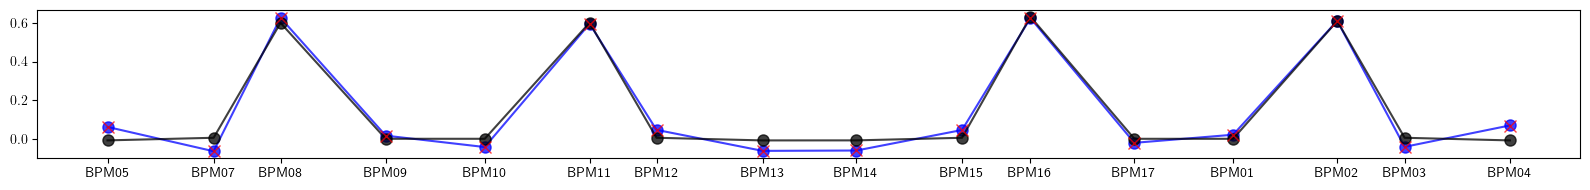

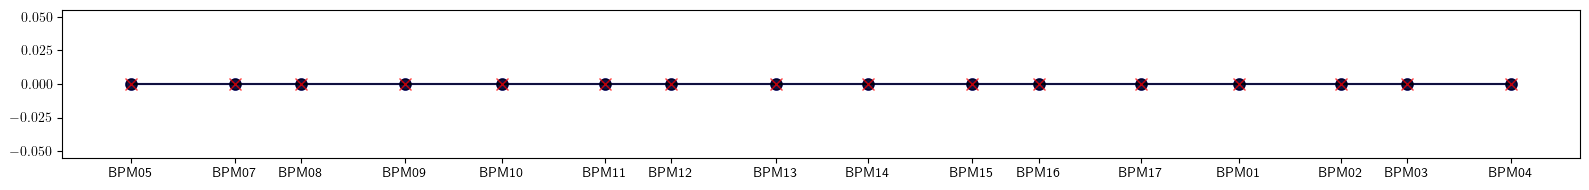

In [12]:
# dxy_dcx

eta_x, eta_y = dispersion_knob(cx + dcx, cy, kn, ks)
detaqx, detaqy = dxy_dcx @ dcx

plt.figure(figsize=(16, 2))
plt.errorbar(ring.locations().cpu().numpy(), eta_x.cpu().numpy(), fmt='-', color='blue', marker='o', ms=8, alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), etaqx.cpu().numpy(), fmt='-', color='black', marker='o', ms=8, alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqx + detaqx).cpu().numpy(), fmt=' ', color='red', marker='x', ms=8, alpha=0.75)
plt.xticks(ticks=ring.locations(), labels=dict.fromkeys([name for name, kind, *_ in ring.layout() if kind == 'BPM']))
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 2))
plt.errorbar(ring.locations().cpu().numpy(), eta_y.cpu().numpy(), fmt='-', color='blue', marker='o', ms=8, alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), etaqy.cpu().numpy(), fmt='-', color='black', marker='o', ms=8, alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqy + detaqy).cpu().numpy(), fmt=' ', color='red', marker='x', ms=8, alpha=0.75)
plt.xticks(ticks=ring.locations(), labels=dict.fromkeys([name for name, kind, *_ in ring.layout() if kind == 'BPM']))
plt.tight_layout()
plt.show()

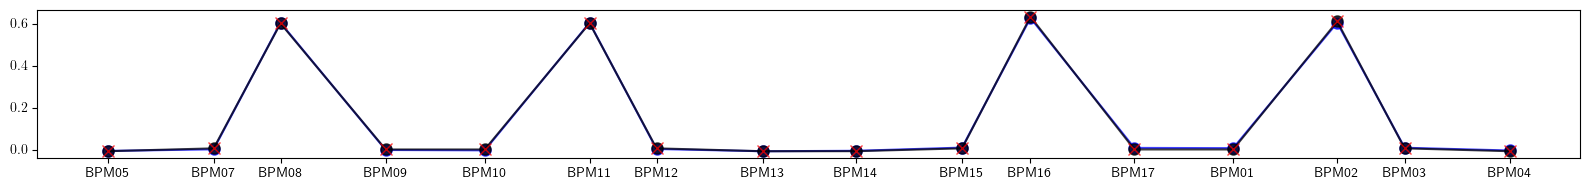

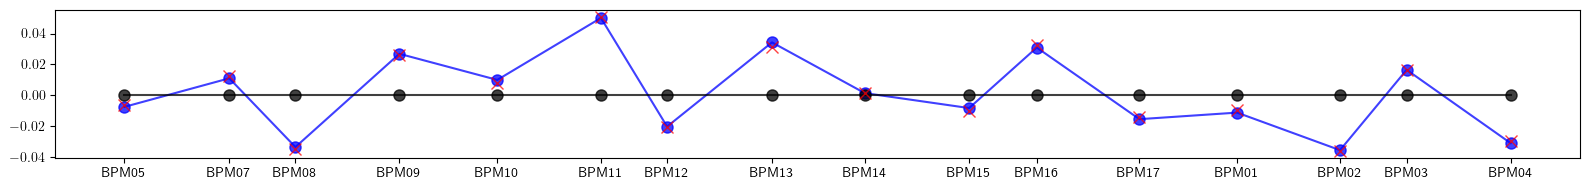

In [13]:
# dxy_dcy

eta_x, eta_y = dispersion_knob(cx, cy + dcy, kn, ks)
detaqx, detaqy = dxy_dcy @ dcy

plt.figure(figsize=(16, 2))
plt.errorbar(ring.locations().cpu().numpy(), eta_x.cpu().numpy(), fmt='-', color='blue', marker='o', ms=8, alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), etaqx.cpu().numpy(), fmt='-', color='black', marker='o', ms=8, alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqx + detaqx).cpu().numpy(), fmt=' ', color='red', marker='x', ms=8, alpha=0.75)
plt.xticks(ticks=ring.locations(), labels=dict.fromkeys([name for name, kind, *_ in ring.layout() if kind == 'BPM']))
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 2))
plt.errorbar(ring.locations().cpu().numpy(), eta_y.cpu().numpy(), fmt='-', color='blue', marker='o', ms=8, alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), etaqy.cpu().numpy(), fmt='-', color='black', marker='o', ms=8, alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqy + detaqy).cpu().numpy(), fmt=' ', color='red', marker='x', ms=8, alpha=0.75)
plt.xticks(ticks=ring.locations(), labels=dict.fromkeys([name for name, kind, *_ in ring.layout() if kind == 'BPM']))
plt.tight_layout()
plt.show()

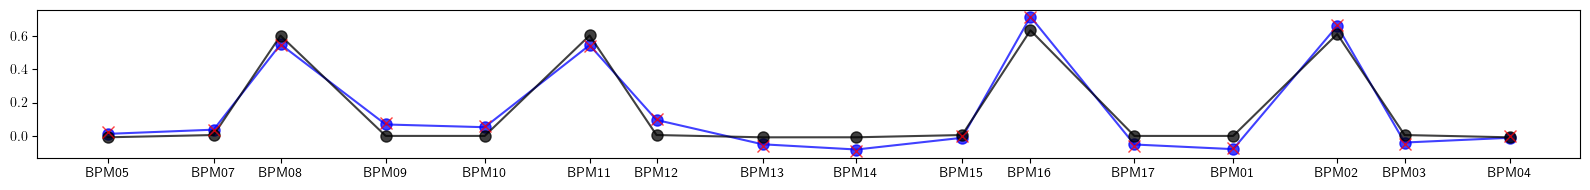

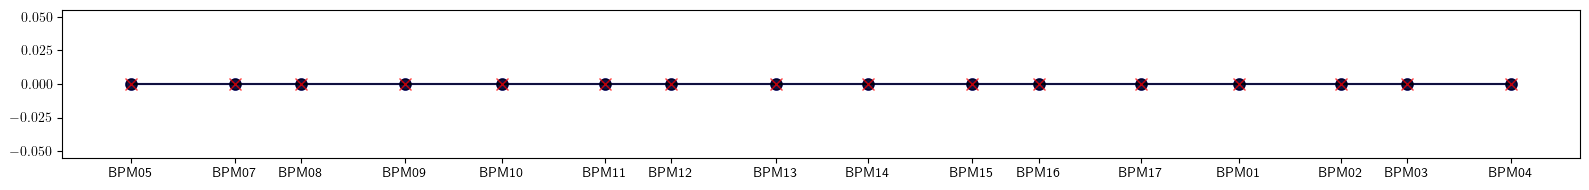

In [14]:
# dxy_dkn

eta_x, eta_y = dispersion_knob(cx, cy, kn + dkn, ks)
detaqx, detaqy = dxy_dkn @ dkn

plt.figure(figsize=(16, 2))
plt.errorbar(ring.locations().cpu().numpy(), eta_x.cpu().numpy(), fmt='-', color='blue', marker='o', ms=8, alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), etaqx.cpu().numpy(), fmt='-', color='black', marker='o', ms=8, alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqx + detaqx).cpu().numpy(), fmt=' ', color='red', marker='x', ms=8, alpha=0.75)
plt.xticks(ticks=ring.locations(), labels=dict.fromkeys([name for name, kind, *_ in ring.layout() if kind == 'BPM']))
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 2))
plt.errorbar(ring.locations().cpu().numpy(), eta_y.cpu().numpy(), fmt='-', color='blue', marker='o', ms=8, alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), etaqy.cpu().numpy(), fmt='-', color='black', marker='o', ms=8, alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqy + detaqy).cpu().numpy(), fmt=' ', color='red', marker='x', ms=8, alpha=0.75)
plt.xticks(ticks=ring.locations(), labels=dict.fromkeys([name for name, kind, *_ in ring.layout() if kind == 'BPM']))
plt.tight_layout()
plt.show()

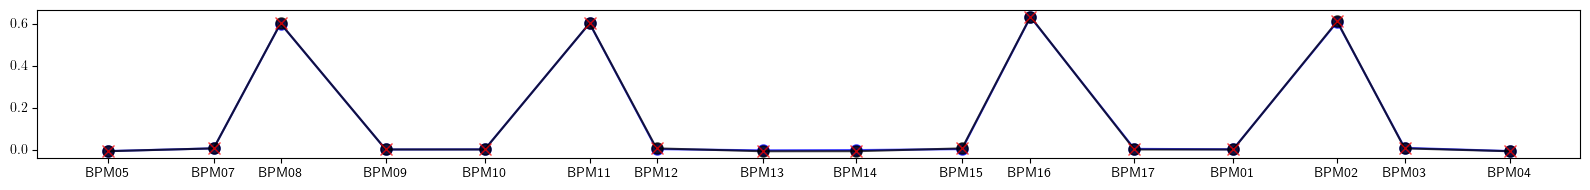

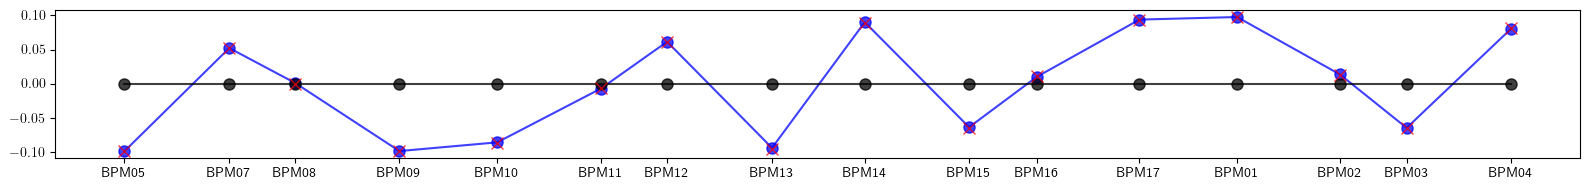

In [15]:
# dxy_dks

eta_x, eta_y = dispersion_knob(cx, cy, kn, ks + dks)
detaqx, detaqy = dxy_dks @ dks

plt.figure(figsize=(16, 2))
plt.errorbar(ring.locations().cpu().numpy(), eta_x.cpu().numpy(), fmt='-', color='blue', marker='o', ms=8, alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), etaqx.cpu().numpy(), fmt='-', color='black', marker='o', ms=8, alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqx + detaqx).cpu().numpy(), fmt=' ', color='red', marker='x', ms=8, alpha=0.75)
plt.xticks(ticks=ring.locations(), labels=dict.fromkeys([name for name, kind, *_ in ring.layout() if kind == 'BPM']))
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 2))
plt.errorbar(ring.locations().cpu().numpy(), eta_y.cpu().numpy(), fmt='-', color='blue', marker='o', ms=8, alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), etaqy.cpu().numpy(), fmt='-', color='black', marker='o', ms=8, alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqy + detaqy).cpu().numpy(), fmt=' ', color='red', marker='x', ms=8, alpha=0.75)
plt.xticks(ticks=ring.locations(), labels=dict.fromkeys([name for name, kind, *_ in ring.layout() if kind == 'BPM']))
plt.tight_layout()
plt.show()

tensor(0.1492, dtype=torch.float64)
tensor(0.1127, dtype=torch.float64)
tensor(0.0862, dtype=torch.float64)
tensor(0.0666, dtype=torch.float64)
tensor(0.0520, dtype=torch.float64)
tensor(0.0408, dtype=torch.float64)
tensor(0.0322, dtype=torch.float64)
tensor(0.0255, dtype=torch.float64)
tensor(0.0203, dtype=torch.float64)
tensor(0.0162, dtype=torch.float64)
tensor(0.0128, dtype=torch.float64)
tensor(0.0102, dtype=torch.float64)
tensor(0.0081, dtype=torch.float64)
tensor(0.0064, dtype=torch.float64)
tensor(0.0051, dtype=torch.float64)
tensor(0.0040, dtype=torch.float64)
tensor(0.0032, dtype=torch.float64)
tensor(0.0025, dtype=torch.float64)
tensor(0.0020, dtype=torch.float64)
tensor(0.0016, dtype=torch.float64)
tensor(0.0012, dtype=torch.float64)
tensor(0.0010, dtype=torch.float64)
tensor(0.0008, dtype=torch.float64)
tensor(0.0006, dtype=torch.float64)
tensor(0.0005, dtype=torch.float64)
tensor(0.0004, dtype=torch.float64)
tensor(0.0003, dtype=torch.float64)
tensor(0.0002, dtype=torch.f

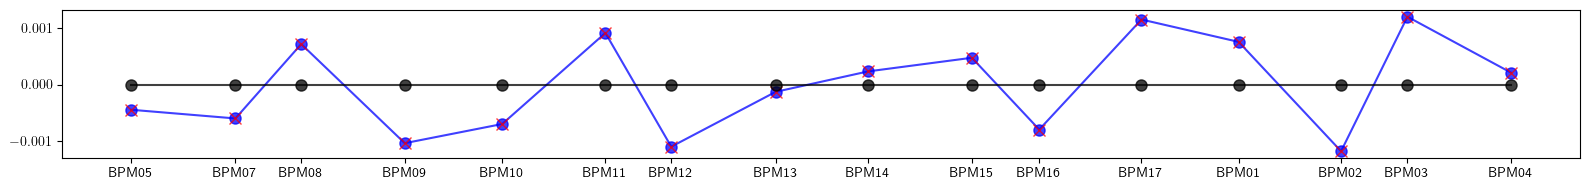

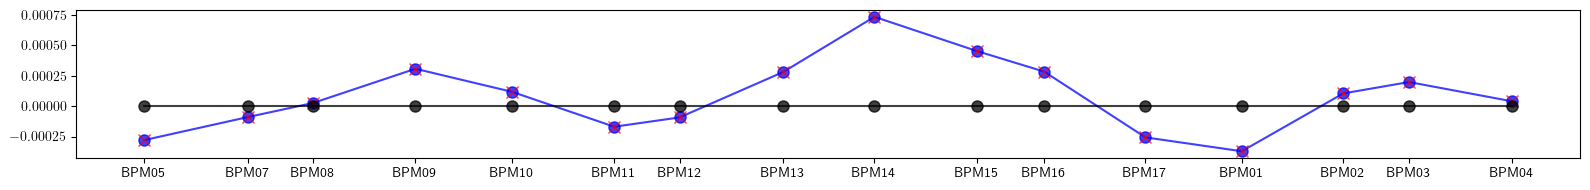

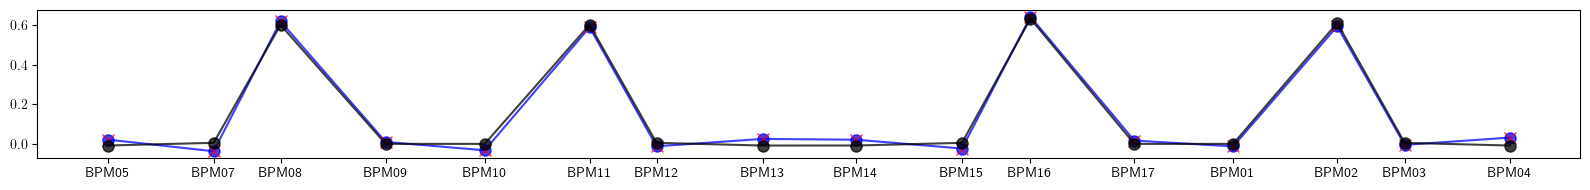

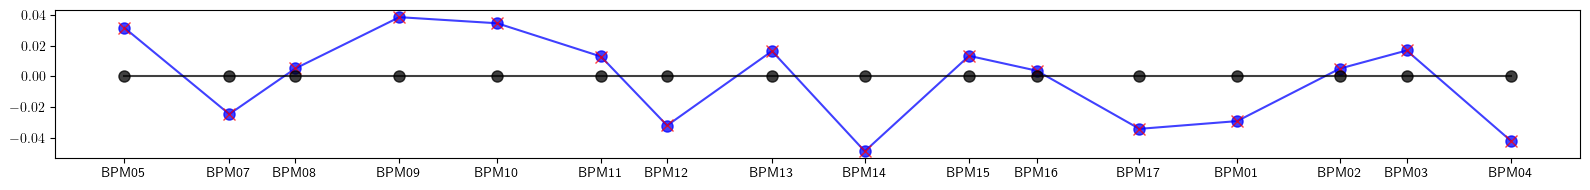

In [16]:
# Fit model to observation

# Set random errors

error_cx = 1.0E-4*torch.randn(nc, dtype=Element.dtype)
error_cy = 1.0E-4*torch.randn(nc, dtype=Element.dtype)
error_kn = 1.0E-1*torch.randn(nq, dtype=Element.dtype)
error_ks = 1.0E-1*torch.randn(nq, dtype=Element.dtype)

# Measure orbit and dispersion

qx_model, qy_model = orbit_knob(cx, cy, kn, ks)
etaqx_model, etaqy_model = dispersion_knob(cx, cy, kn, ks)

qx_error, qy_error = orbit_knob(cx + error_cx, cy + error_cy, kn + error_kn, ks + error_ks)
etaqx_error, etaqy_error = dispersion_knob(cx + error_cx, cy + error_cy, kn + error_kn, ks + error_ks)

# Set initial deviation vectors

cx = torch.zeros(nc, dtype=Element.dtype)
cy = torch.zeros(nc, dtype=Element.dtype)
kn = torch.zeros(nq, dtype=Element.dtype)
ks = torch.zeros(nq, dtype=Element.dtype)

# Construct linear system

# Orbit
# [..., qx_i, ..., qy_i, ....] = M @ [..., cx_i, ...., cy_i, ....]

orm = ORM(ring, guess, [], alignment=False)

# Dispersion (cx, cy)
# [..., etax_i, ..., etay_i, ....] = M @ [..., cx_i, ...., cy_i, ....]

dqxqy_dcxdcy = torch.hstack([dxy_dcx.reshape(-1, nc), dxy_dcy.reshape(-1, nc)])

# Dispersion (kn, ks)
# [..., etax_i, ..., etay_i, ....] = M @ [..., kn_i, ...., ks_i, ....]

dqxqy_dkndks = torch.hstack([dxy_dkn.reshape(-1, nq), dxy_dks.reshape(-1, nq)])

# Full matrix
# [..., qx_i, ..., qy_i, ...., etax_i, ..., etay_i, ...] = M @ [..., cx_i, ...., cy_i, ...., kn_i, ...., ks_i, ....]

response = torch.hstack([torch.vstack([orm, dqxqy_dcxdcy]), torch.vstack([torch.zeros_like(dqxqy_dkndks), dqxqy_dkndks])])

# Fit model to measured    

for _ in range(32):

    # Compure current orbit and dispersion
    
    qx, qy = orbit_knob(cx, cy, kn, ks)
    etaqx, etaqy = dispersion_knob(cx, cy, kn, ks)

    # Compute difference with target values
    
    difference =  torch.cat([qx - qx_error, qy - qy_error, etaqx - etaqx_error, etaqy - etaqy_error])
    
    # Solve linear system

    dcx, dcy, dkn, dks = (-0.25*torch.linalg.lstsq(response, difference, driver='gelsd').solution).split((nc, nc, nq, nq))

    # Adjust knobs
    
    cx += dcx
    cy += dcy
    kn += dkn
    ks += dks

    # Report difference norm

    print(difference.norm())

# Plot orbit

plt.figure(figsize=(16, 2))
plt.errorbar(ring.locations().cpu().numpy(), qx_error.cpu().numpy(), fmt='-', color='blue', marker='o', ms=8, alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), qx.cpu().numpy(), fmt=' ', color='red', marker='x', ms=8, alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), qx_model.cpu().numpy(), fmt='-', color='black', marker='o', ms=8, alpha=0.75)
plt.xticks(ticks=ring.locations(), labels=dict.fromkeys([name for name, kind, *_ in ring.layout() if kind == 'BPM']))
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 2))
plt.errorbar(ring.locations().cpu().numpy(), qy_error.cpu().numpy(), fmt='-', color='blue', marker='o', ms=8, alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), qy.cpu().numpy(), fmt=' ', color='red', marker='x', ms=8, alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), qy_model.cpu().numpy(), fmt='-', color='black', marker='o', ms=8, alpha=0.75)
plt.xticks(ticks=ring.locations(), labels=dict.fromkeys([name for name, kind, *_ in ring.layout() if kind == 'BPM']))
plt.tight_layout()
plt.show()

# Plot dispersion

plt.figure(figsize=(16, 2))
plt.errorbar(ring.locations().cpu().numpy(), etaqx_error.cpu().numpy(), fmt='-', color='blue', marker='o', ms=8, alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), etaqx.cpu().numpy(), fmt=' ', color='red', marker='x', ms=8, alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), etaqx_model.cpu().numpy(), fmt='-', color='black', marker='o', ms=8, alpha=0.75)
plt.xticks(ticks=ring.locations(), labels=dict.fromkeys([name for name, kind, *_ in ring.layout() if kind == 'BPM']))
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 2))
plt.errorbar(ring.locations().cpu().numpy(), etaqy_error.cpu().numpy(), fmt='-', color='blue', marker='o', ms=8, alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), etaqy.cpu().numpy(), fmt=' ', color='red', marker='x', ms=8, alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), etaqy_model.cpu().numpy(), fmt='-', color='black', marker='o', ms=8, alpha=0.75)
plt.xticks(ticks=ring.locations(), labels=dict.fromkeys([name for name, kind, *_ in ring.layout() if kind == 'BPM']))
plt.tight_layout()
plt.show()

In [17]:
# Set parametric observables

def knob(cx, cy, kn, ks):
    
    guess = torch.zeros(4, dtype=Element.dtype)
    points, *_ = orbit(ring, 
                       guess, 
                       [cx, cy, kn, ks], 
                       ('cx', ['Corrector'] , None, None), 
                       ('cy', ['Corrector'] , None, None), 
                       ('kn', ['Quadrupole'], None, None), 
                       ('ks', ['Quadrupole'], None, None),                     
                       advance=True, 
                       full=False, 
                       alignment=False, 
                       limit=8, 
                       epsilon=1.0E-6, 
                       jacobian=torch.func.jacrev)
    
    qx, _, qy, _ = points.T

    guess, *_ = points
    etax, _, etay, _ = dispersion(ring,
                                  guess, 
                                  [cx, cy, kn, ks], 
                                  ('cx', ['Corrector'] , None, None), 
                                  ('cy', ['Corrector'] , None, None), 
                                  ('kn', ['Quadrupole'], None, None), 
                                  ('ks', ['Quadrupole'], None, None),                     
                                  alignment=False, 
                                  limit=1, 
                                  epsilon=1.0E-6, 
                                  jacobian=torch.func.jacrev)
    
    return torch.stack([qx, qy, etax, etay])

In [18]:
# Test with zero deviations

cx = torch.zeros(nc, dtype=Element.dtype)
cy = torch.zeros(nc, dtype=Element.dtype)
kn = torch.zeros(nq, dtype=Element.dtype)
ks = torch.zeros(nq, dtype=Element.dtype)

print(knob(cx, cy, kn, ks).shape)

torch.Size([4, 16])


In [19]:
# Set objective funtion

def objective(cx, cy, kn, ks):
    qx, qy, etax, etay = knob(cx, cy, kn, ks)
    return (((qx - qx_error)**2).sum() + ((qy - qy_error)**2).sum() + ((etax - etaqx_error)**2).sum() + ((etay - etaqy_error)**2).sum()).sqrt()

print(objective(cx, cy, kn, ks))
print(objective(error_cx, error_cy, error_kn, error_ks))

tensor(0.1492, dtype=torch.float64)
tensor(1.4960e-14, dtype=torch.float64)


tensor(0.1492, dtype=torch.float64)
tensor(0.1125, dtype=torch.float64)
tensor(0.0831, dtype=torch.float64)
tensor(0.0875, dtype=torch.float64)
tensor(0.0606, dtype=torch.float64)
tensor(0.0509, dtype=torch.float64)
tensor(0.0352, dtype=torch.float64)
tensor(0.0445, dtype=torch.float64)
tensor(0.0305, dtype=torch.float64)
tensor(0.0395, dtype=torch.float64)
tensor(0.0347, dtype=torch.float64)
tensor(0.0380, dtype=torch.float64)
tensor(0.0349, dtype=torch.float64)
tensor(0.0238, dtype=torch.float64)
tensor(0.0253, dtype=torch.float64)
tensor(0.0228, dtype=torch.float64)
tensor(0.0223, dtype=torch.float64)
tensor(0.0162, dtype=torch.float64)
tensor(0.0165, dtype=torch.float64)
tensor(0.0201, dtype=torch.float64)
tensor(0.0185, dtype=torch.float64)
tensor(0.0155, dtype=torch.float64)
tensor(0.0139, dtype=torch.float64)
tensor(0.0160, dtype=torch.float64)
tensor(0.0126, dtype=torch.float64)
tensor(0.0099, dtype=torch.float64)
tensor(0.0117, dtype=torch.float64)
tensor(0.0126, dtype=torch.f

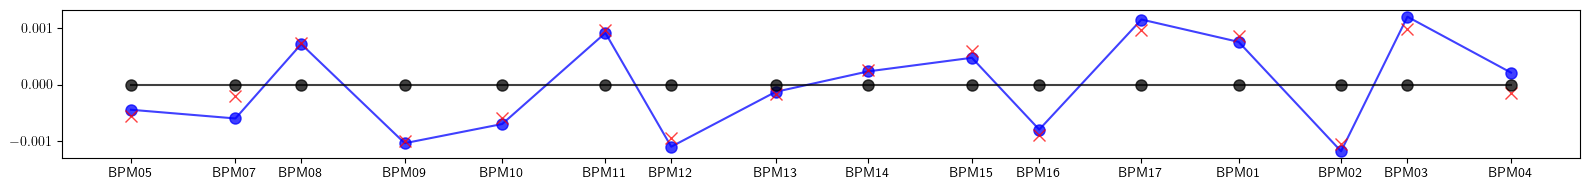

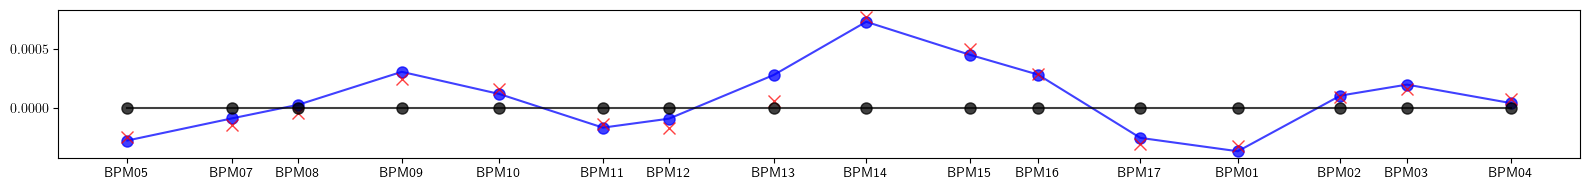

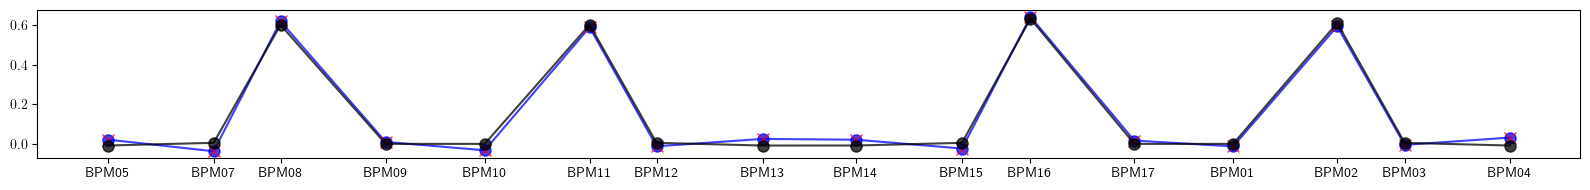

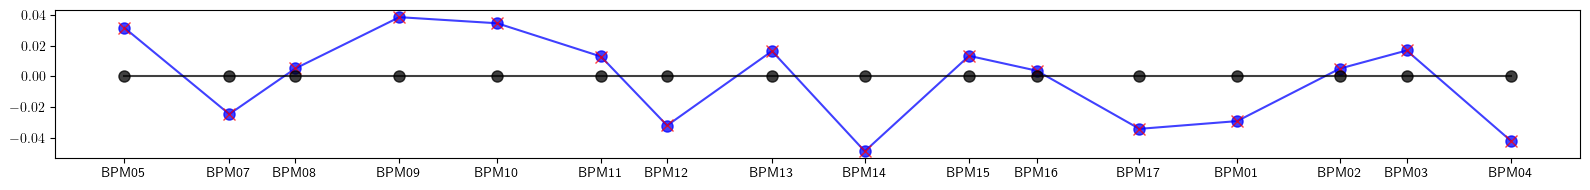

In [20]:
# Fit

# Set initial deviations

cx = torch.zeros(nc, dtype=Element.dtype)
cy = torch.zeros(nc, dtype=Element.dtype)
kn = torch.zeros(nq, dtype=Element.dtype )
ks = torch.zeros(nq, dtype=Element.dtype )

# Set objective

def objective(cx, cy, kn, ks):
    qx, qy, etax, etay = knob(cx, cy, kn, ks)
    return (((qx - qx_error)**2).sum() + ((qy - qy_error)**2).sum() + ((etax - etaqx_error)**2).sum() + ((etay - etaqy_error)**2).sum()).sqrt()

# Set parameter box

box = [(-5E-4, +5E-4), (-5E-4, +5E-4), (-0.5, 0.5), (-0.5, 0.5)]

# Normalize objective

objective = normalize(objective, box)

# Transform initials

cx, cy, kn, ks, *_ = forward([cx, cy, kn, ks], box)

# Set model

model = Wrapper(objective, cx, cy, kn, ks)

# Set optimizer

optimizer = torch.optim.Adam(model.parameters(), lr=0.0175)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.9975)

# Fit

for epoch in range(256):
    value = model()
    value.backward()
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
    print(value.detach())

# Compare with target

qx, qy, etax, etay = knob(*inverse([cx, cy, kn, ks], box))

# Plot orbit

plt.figure(figsize=(16, 2))
plt.errorbar(ring.locations().cpu().numpy(), qx_error.cpu().numpy(), fmt='-', color='blue', marker='o', ms=8, alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), qx.cpu().numpy(), fmt=' ', color='red', marker='x', ms=8, alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), qx_model.cpu().numpy(), fmt='-', color='black', marker='o', ms=8, alpha=0.75)
plt.xticks(ticks=ring.locations(), labels=dict.fromkeys([name for name, kind, *_ in ring.layout() if kind == 'BPM']))
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 2))
plt.errorbar(ring.locations().cpu().numpy(), qy_error.cpu().numpy(), fmt='-', color='blue', marker='o', ms=8, alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), qy.cpu().numpy(), fmt=' ', color='red', marker='x', ms=8, alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), qy_model.cpu().numpy(), fmt='-', color='black', marker='o', ms=8, alpha=0.75)
plt.xticks(ticks=ring.locations(), labels=dict.fromkeys([name for name, kind, *_ in ring.layout() if kind == 'BPM']))
plt.tight_layout()
plt.show()

# Plot dispersion

plt.figure(figsize=(16, 2))
plt.errorbar(ring.locations().cpu().numpy(), etaqx_error.cpu().numpy(), fmt='-', color='blue', marker='o', ms=8, alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), etaqx.cpu().numpy(), fmt=' ', color='red', marker='x', ms=8, alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), etaqx_model.cpu().numpy(), fmt='-', color='black', marker='o', ms=8, alpha=0.75)
plt.xticks(ticks=ring.locations(), labels=dict.fromkeys([name for name, kind, *_ in ring.layout() if kind == 'BPM']))
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 2))
plt.errorbar(ring.locations().cpu().numpy(), etaqy_error.cpu().numpy(), fmt='-', color='blue', marker='o', ms=8, alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), etaqy.cpu().numpy(), fmt=' ', color='red', marker='x', ms=8, alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), etaqy_model.cpu().numpy(), fmt='-', color='black', marker='o', ms=8, alpha=0.75)
plt.xticks(ticks=ring.locations(), labels=dict.fromkeys([name for name, kind, *_ in ring.layout() if kind == 'BPM']))
plt.tight_layout()
plt.show()